In [ ]:
onehot de todo y csatboost

selecciones de montse 

tabla comparando resultados con ponderacion

preguntar edad

In [2]:
%pip install catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-5.20.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 8.0 MB/s eta 0:00:0000:0100:01
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Using cached plotly-5.20.0-py3-none-any.whl (15.7 MB)
Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from datetime import datetime


In [182]:
# Función para obtener el nombre del día de la semana
def get_weekday_name(day, month,year):
    meses_dict = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    month_num = meses_dict[month.lower()]  # Convierte el nombre del mes a número
    date_obj = datetime(year, month_num, day)
    return date_obj.strftime('%A')  # Devuelve el nombre completo del día de la semana

In [191]:
def cleaning(data):
    cond_balance = [(data['balance'] < 0),(data['balance'] >= 0) & (data['balance'] < 100),(data['balance'] >= 100) & (data['balance'] < 500),(data['balance'] >= 500) & (data['balance'] < 1000),  (data['balance'] >= 1000) & (data['balance'] < 1500),  (data['balance'] >= 1500)] 
    cond_duration = [(data['duration'] >= 0) & (data['duration'] < 5),(data['duration'] >= 5) & (data['duration'] < 10),(data['duration'] > 10)]
    choice_balance = ['negativo', '0-100', '100-500','500-1000', '1000-1500', ' > 1500'] 
    choice_duration = ['<5', '5 - 10', '10>0 ']
    year=2016
    dias_semana_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    data['balance'] = np.select(cond_balance, choice_balance, default='Other')
    data['duration'] = data['duration']/60
    data['duration'] = np.select(cond_duration, choice_duration, default='Other')
    data['pdays'] = np.where(data['pdays'] == -1, 0, 1)
    data['previous'] = np.where(data['previous'] == 0, 0, 1)
    data['dia_semana'] = data.apply(lambda row: get_weekday_name(row['day'], row['month'],year), axis=1)
    #data['dia_semana'] = pd.Categorical(data['dia_semana'], categories=dias_semana_ordenados, ordered=True)
    data=data[~data['car'].isnull()]
    data=data[~data.duplicated()]
    data['subscribed']=data['subscribed'].map({'yes':1,
                                                 'no':0})
    return data


In [192]:
data_raw=pd.read_csv('../../Data/Raw/bank-full.csv',sep=';')
data_cleaned=cleaning(data_raw)

<Axes: >

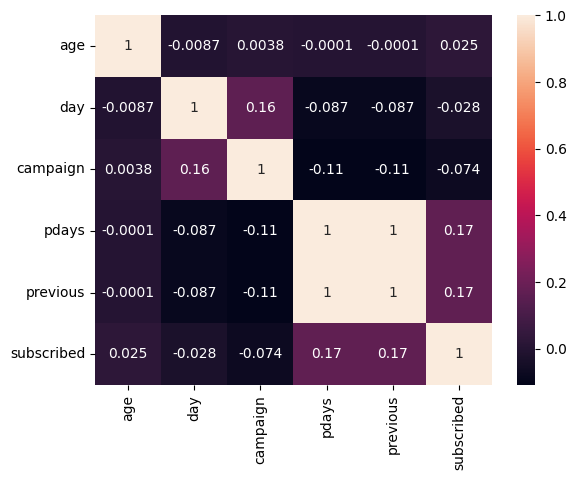

In [185]:
num_cols=data_cleaned.select_dtypes(include='number').columns
sns.heatmap(data_cleaned[num_cols].corr(),annot=True)

In [186]:
data_cleaned.drop('pdays',axis=1,inplace=True)
data_cleaned_cat_num=data_cleaned.copy()    #Para probar seleccion de variables Filter y Wrapper

In [187]:
def cat_to_num(col,objective,data): #Proceso similar al que sigue CatboostClassifier
    dic={}
    for opt in data[col].unique():
        mask=data[col]==opt
        valor=round(data[mask][objective].sum() / len(data[mask]),3)
        dic[opt]=valor

    data[col]=data[col].map(dic)
    data[col]=data[col].astype(float)


In [188]:
cat_cols=data_cleaned.select_dtypes(include=['O']).columns
ids_cat=[id for id,col in enumerate(data_cleaned.columns) if col in cat_cols]

for cl in data_cleaned_cat_num.select_dtypes(include=['O','category']).columns:
    cat_to_num(cl,'subscribed',data_cleaned_cat_num)

In [194]:
y=data_cleaned['subscribed']
X=data_cleaned.drop('subscribed',axis=1)
cat_cols=X.select_dtypes(include=['O']).columns
ids_cat=[id for id,col in enumerate(X.columns) if col in cat_cols]

# Seleccion con Catboost
---

In [195]:
clf=CatBoostClassifier(random_state=0,cat_features=ids_cat)
clf.fit(X,y)

Learning rate set to 0.0522
0:	learn: 0.6465525	total: 79.3ms	remaining: 1m 19s
1:	learn: 0.6083530	total: 121ms	remaining: 1m
2:	learn: 0.5750260	total: 167ms	remaining: 55.4s
3:	learn: 0.5458156	total: 199ms	remaining: 49.6s
4:	learn: 0.5190174	total: 242ms	remaining: 48.2s
5:	learn: 0.4960776	total: 280ms	remaining: 46.3s
6:	learn: 0.4767795	total: 296ms	remaining: 42s
7:	learn: 0.4587647	total: 335ms	remaining: 41.5s
8:	learn: 0.4418570	total: 383ms	remaining: 42.2s
9:	learn: 0.4272858	total: 421ms	remaining: 41.7s
10:	learn: 0.4159411	total: 439ms	remaining: 39.4s
11:	learn: 0.4051939	total: 478ms	remaining: 39.4s
12:	learn: 0.3962596	total: 500ms	remaining: 38s
13:	learn: 0.3870488	total: 522ms	remaining: 36.8s
14:	learn: 0.3782523	total: 564ms	remaining: 37s
15:	learn: 0.3709508	total: 599ms	remaining: 36.8s
16:	learn: 0.3643806	total: 631ms	remaining: 36.5s
17:	learn: 0.3584789	total: 673ms	remaining: 36.7s
18:	learn: 0.3542837	total: 696ms	remaining: 35.9s
19:	learn: 0.3487869

In [196]:
result=pd.DataFrame(zip(clf.feature_importances_,clf.feature_names_),columns=['import','var']).sort_values('import',ascending=False)
result

,import,var
11,17.076303,month
10,12.318335,day
16,10.266120,poutcome
9,10.239119,contact
0,8.656046,age
17,6.603719,dia_semana
6,5.373420,housing
1,5.263587,job
13,5.116718,campaign
5,4.876910,balance


## Seleccion con Ridge
---

In [197]:
X_cat_num=data_cleaned_cat_num.drop('subscribed',axis=1)
y_cat_num=data_cleaned_cat_num['subscribed']

In [198]:
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=0.01, solver = 'auto', random_state = 9) #Si selecionamos alpha = 0 se correspondería con una regresión lineal sin penalización
ridge_regression.fit(X_cat_num, y_cat_num)
ridge_regression.coef_

array([-9.91947495e-05,  3.40388999e-01,  2.99751524e-01,  1.55564221e-01,
       -1.34025231e-01,  4.50734739e-01,  4.07965046e-01,  4.21784742e-01,
        2.99751524e-01,  3.28736512e-01, -6.87357887e-06,  6.22735602e-01,
        8.85101718e-01, -4.05892221e-03, -3.36213806e-02,  8.61554918e-01,
        2.51619671e-01])